In [14]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
from hydra.utils import instantiate
from hydra import initialize, compose
import hydra
from omegaconf import OmegaConf

from data.dataManager import DataManager
from model.modelCreator import ModelCreator

from scripts.Frobenius import CorrelationMetrics, create_filenames_dict, load_engine
from scripts.Jet_metrics import get_fpd_kpd_metrics, HepMetrics
from utils.correlation_plotting import correlation_plots
from scripts.run import setup_model, load_model_instance
from utils.HighLevelFeatsAtlasReg import HighLevelFeatures_ATLAS_regular as HLF2


# testing rbm
from utils.rbm_plots import plot_rbm_histogram, plot_rbm_params
import wandb
import importlib

In [2]:
from hydra.core.global_hydra import GlobalHydra
GlobalHydra.instance().clear()

initialize(version_base=None, config_path="config")
config = compose(config_name="config.yaml")
wandb.init(tags = [config.data.dataset_name], project=config.wandb.project, entity=config.wandb.entity, config=OmegaConf.to_container(config, resolve=True), mode='disabled')


In [3]:
new_model = False
if new_model:
    self = setup_model(config)
    # self.model = self.model.double()  # sets all model parameters to float64
else:
    self = load_model_instance(config)
    # self.model = self.model.double()

[17:14:02.993] INFO   data.dataManager                                  Loading ATLAS dataset: AtlasReg000New
[17:14:04.750] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fa06da1f7a0>: 119999 events, 469 batches
[17:14:04.751] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fa06da47170>: 15001 events, 15 batches
[17:14:04.752] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fa06da47770>: 14999 events, 15 batches
[17:14:04.753] INFO   model.modelCreator                                ::Creating Model
[17:14:04.946] INFO   dwave.cloud.client.base                           Fetching definitions of all available solvers
[17:14:04.980] INFO   dwave.cloud.client.base                           Received solver data for 7 solver(s).
[17:14:05.222] INFO   dwave.cloud.client.base                           Adding 

2048 first subdecoder


[17:14:07.384] INFO   scripts.run                                       Requesting GPUs. GPU list :[2]
[17:14:07.385] INFO   scripts.run                                       Main GPU : cuda:2
[17:14:07.522] INFO   scripts.run                                       CUDA available


cuda:2


[17:14:07.860] INFO   model.modelCreator                                Loading state
[17:14:08.120] INFO   model.modelCreator                                Loading weights from file : /fast_scratch_1/caloqvae/lzhu/wandb/run-20250911_220658-vfk8njxx/files/autoencoderbase_249.pth


Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _bce_loss
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder


[17:14:08.625] ERROR  model.modelCreator                                Failed to load VAE optimizer state: loaded state dict contains a parameter group that doesn't match the size of optimizer's group
[17:14:08.637] INFO   model.modelCreator                                Loaded RBM optimizer state


In [4]:
self.evaluate_trivial()

[17:15:28.297] INFO   engine.engine                                     Epoch: 0 - Average Val Loss: 5914.7631


Processed batch 1
Processed batch 2
Processed batch 3
Processed batch 4
Processed batch 5
Processed batch 6
Processed batch 7
Processed batch 8
Processed batch 9
Processed batch 10
Processed batch 11
Processed batch 12
Processed batch 13
Processed batch 14
Processed batch 15


/home/leozhu/CaloQuVAE/utils/plots.py:94: UserWarning: The figure layout has changed to tight
  energy_sum_layer_fig.tight_layout()
/home/leozhu/CaloQuVAE/utils/plots.py:95: UserWarning: The figure layout has changed to tight
  incidence_ratio_layer_fig.tight_layout()
/home/leozhu/CaloQuVAE/utils/plots.py:96: UserWarning: The figure layout has changed to tight
  target_recon_ratio_layer_fig.tight_layout()
/home/leozhu/CaloQuVAE/utils/plots.py:97: UserWarning: The figure layout has changed to tight
  sparsity_layer_fig.tight_layout()


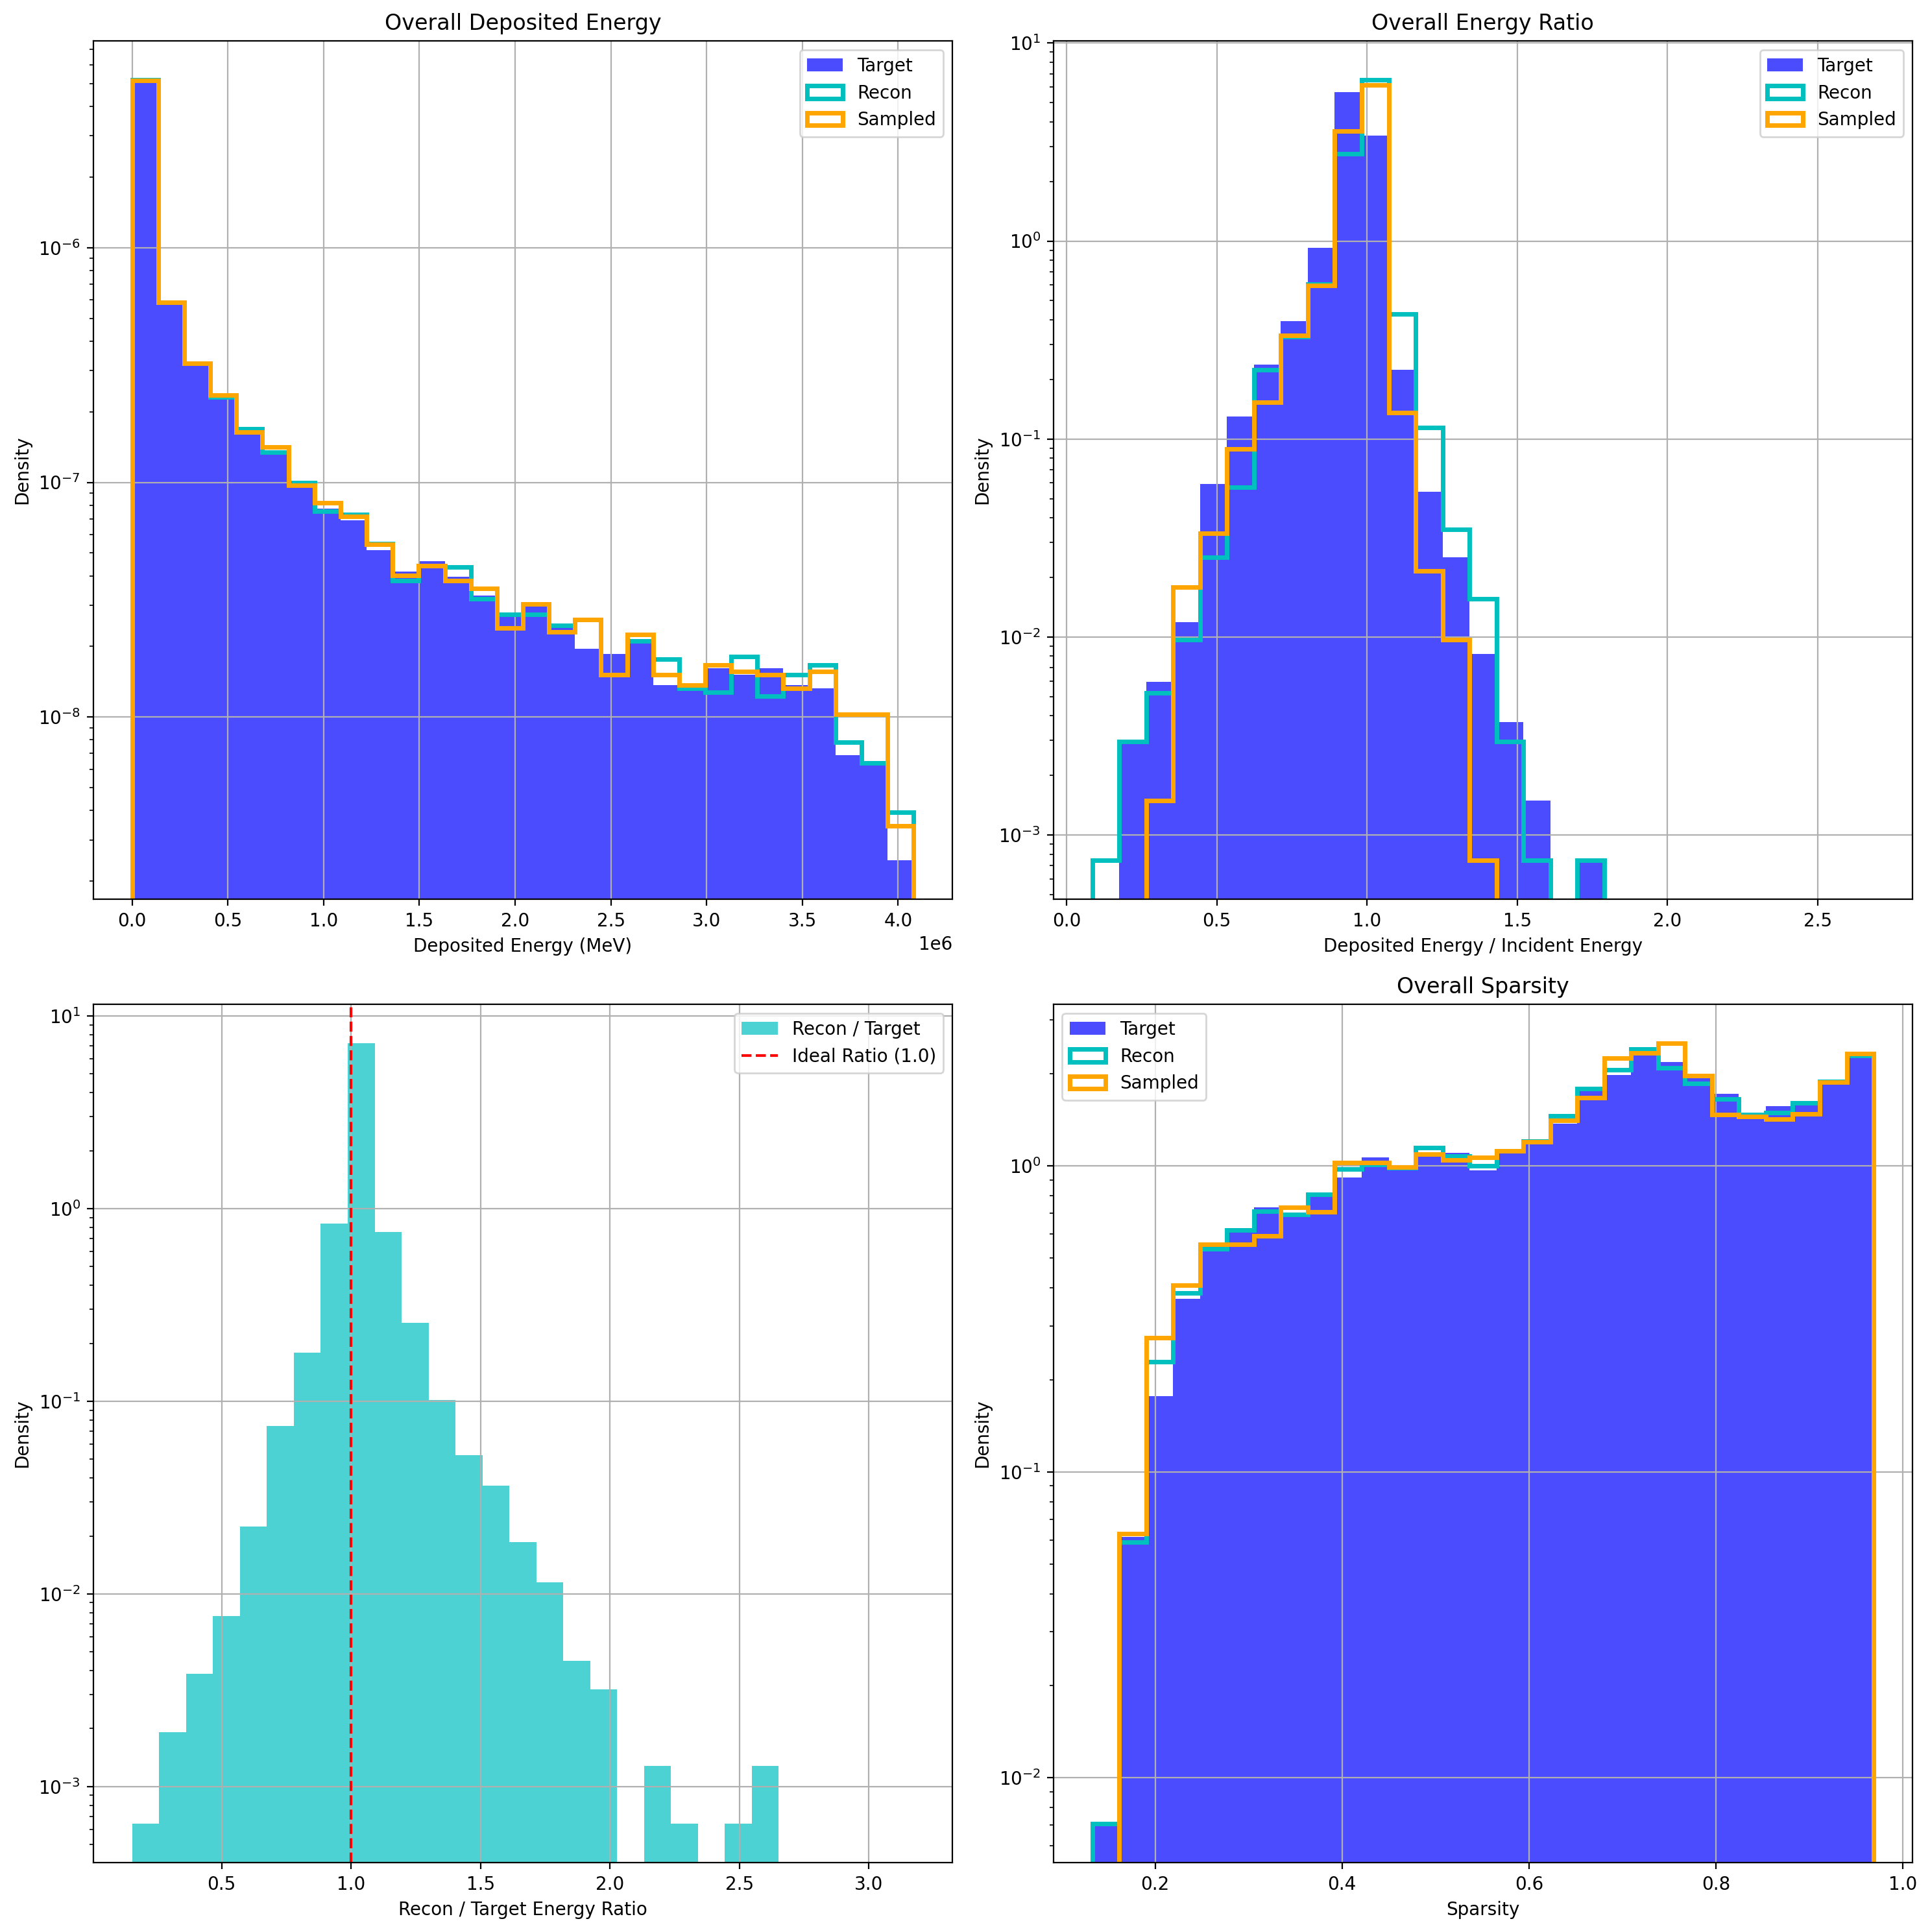

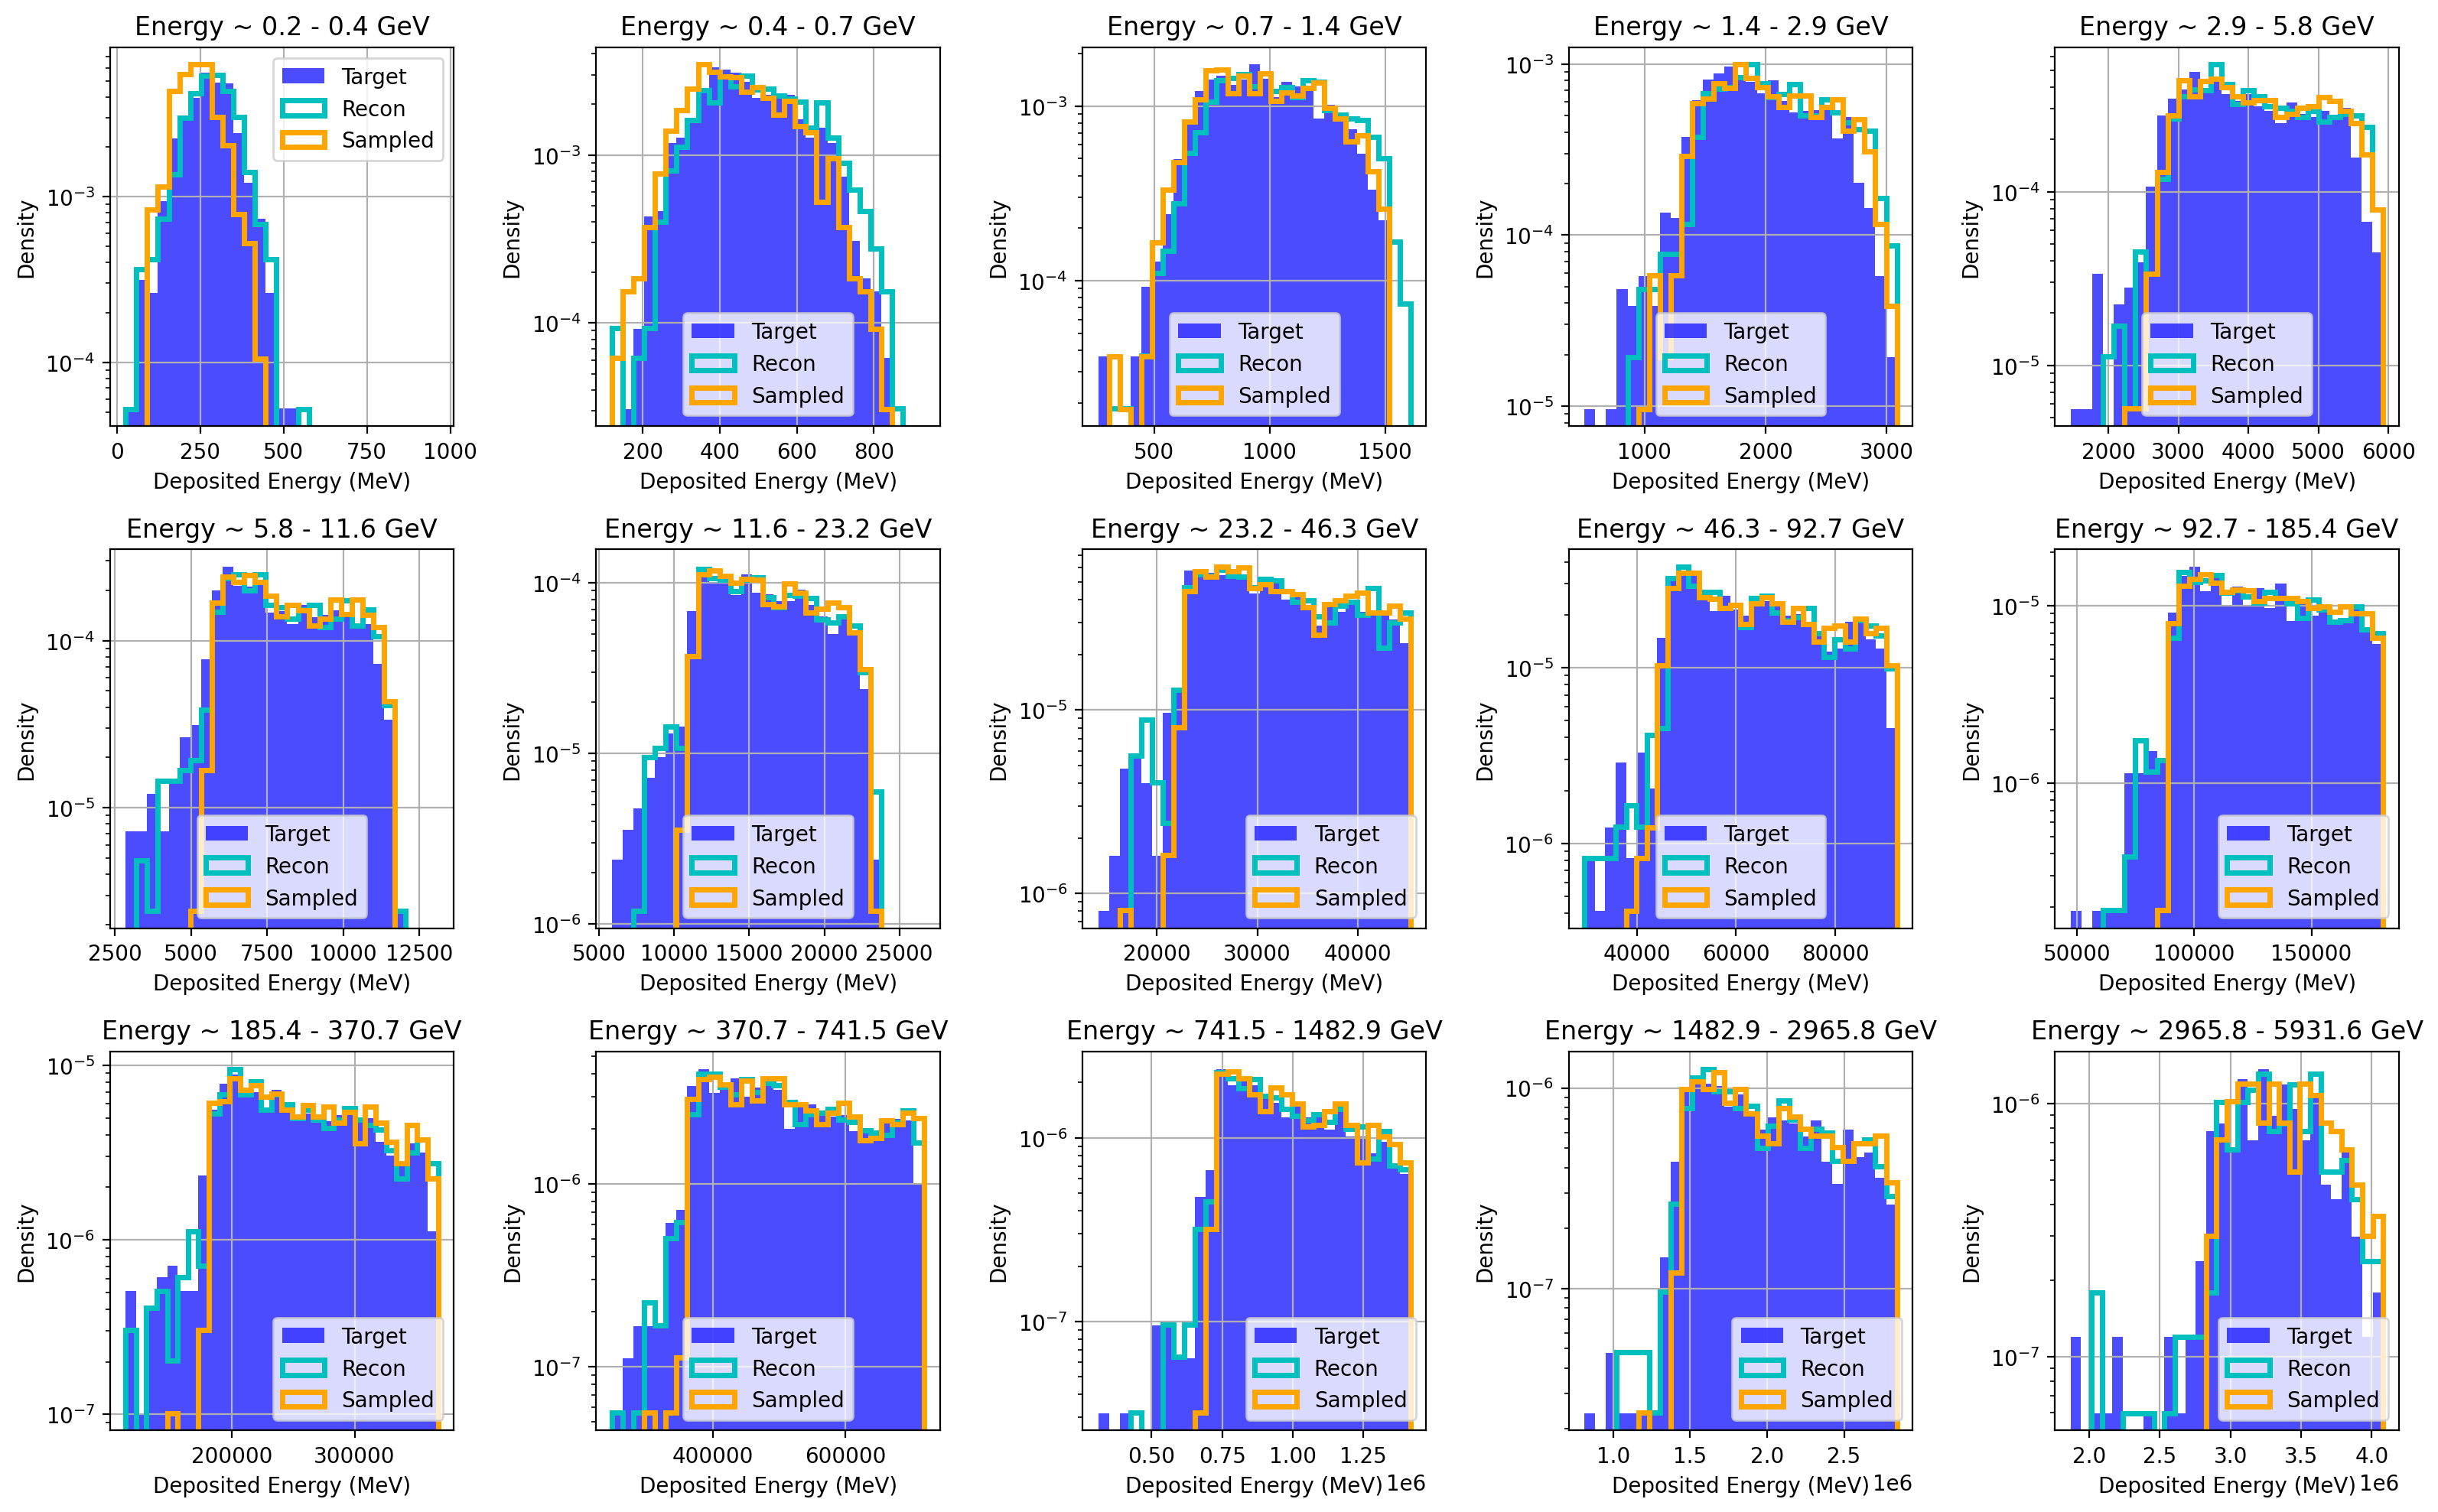

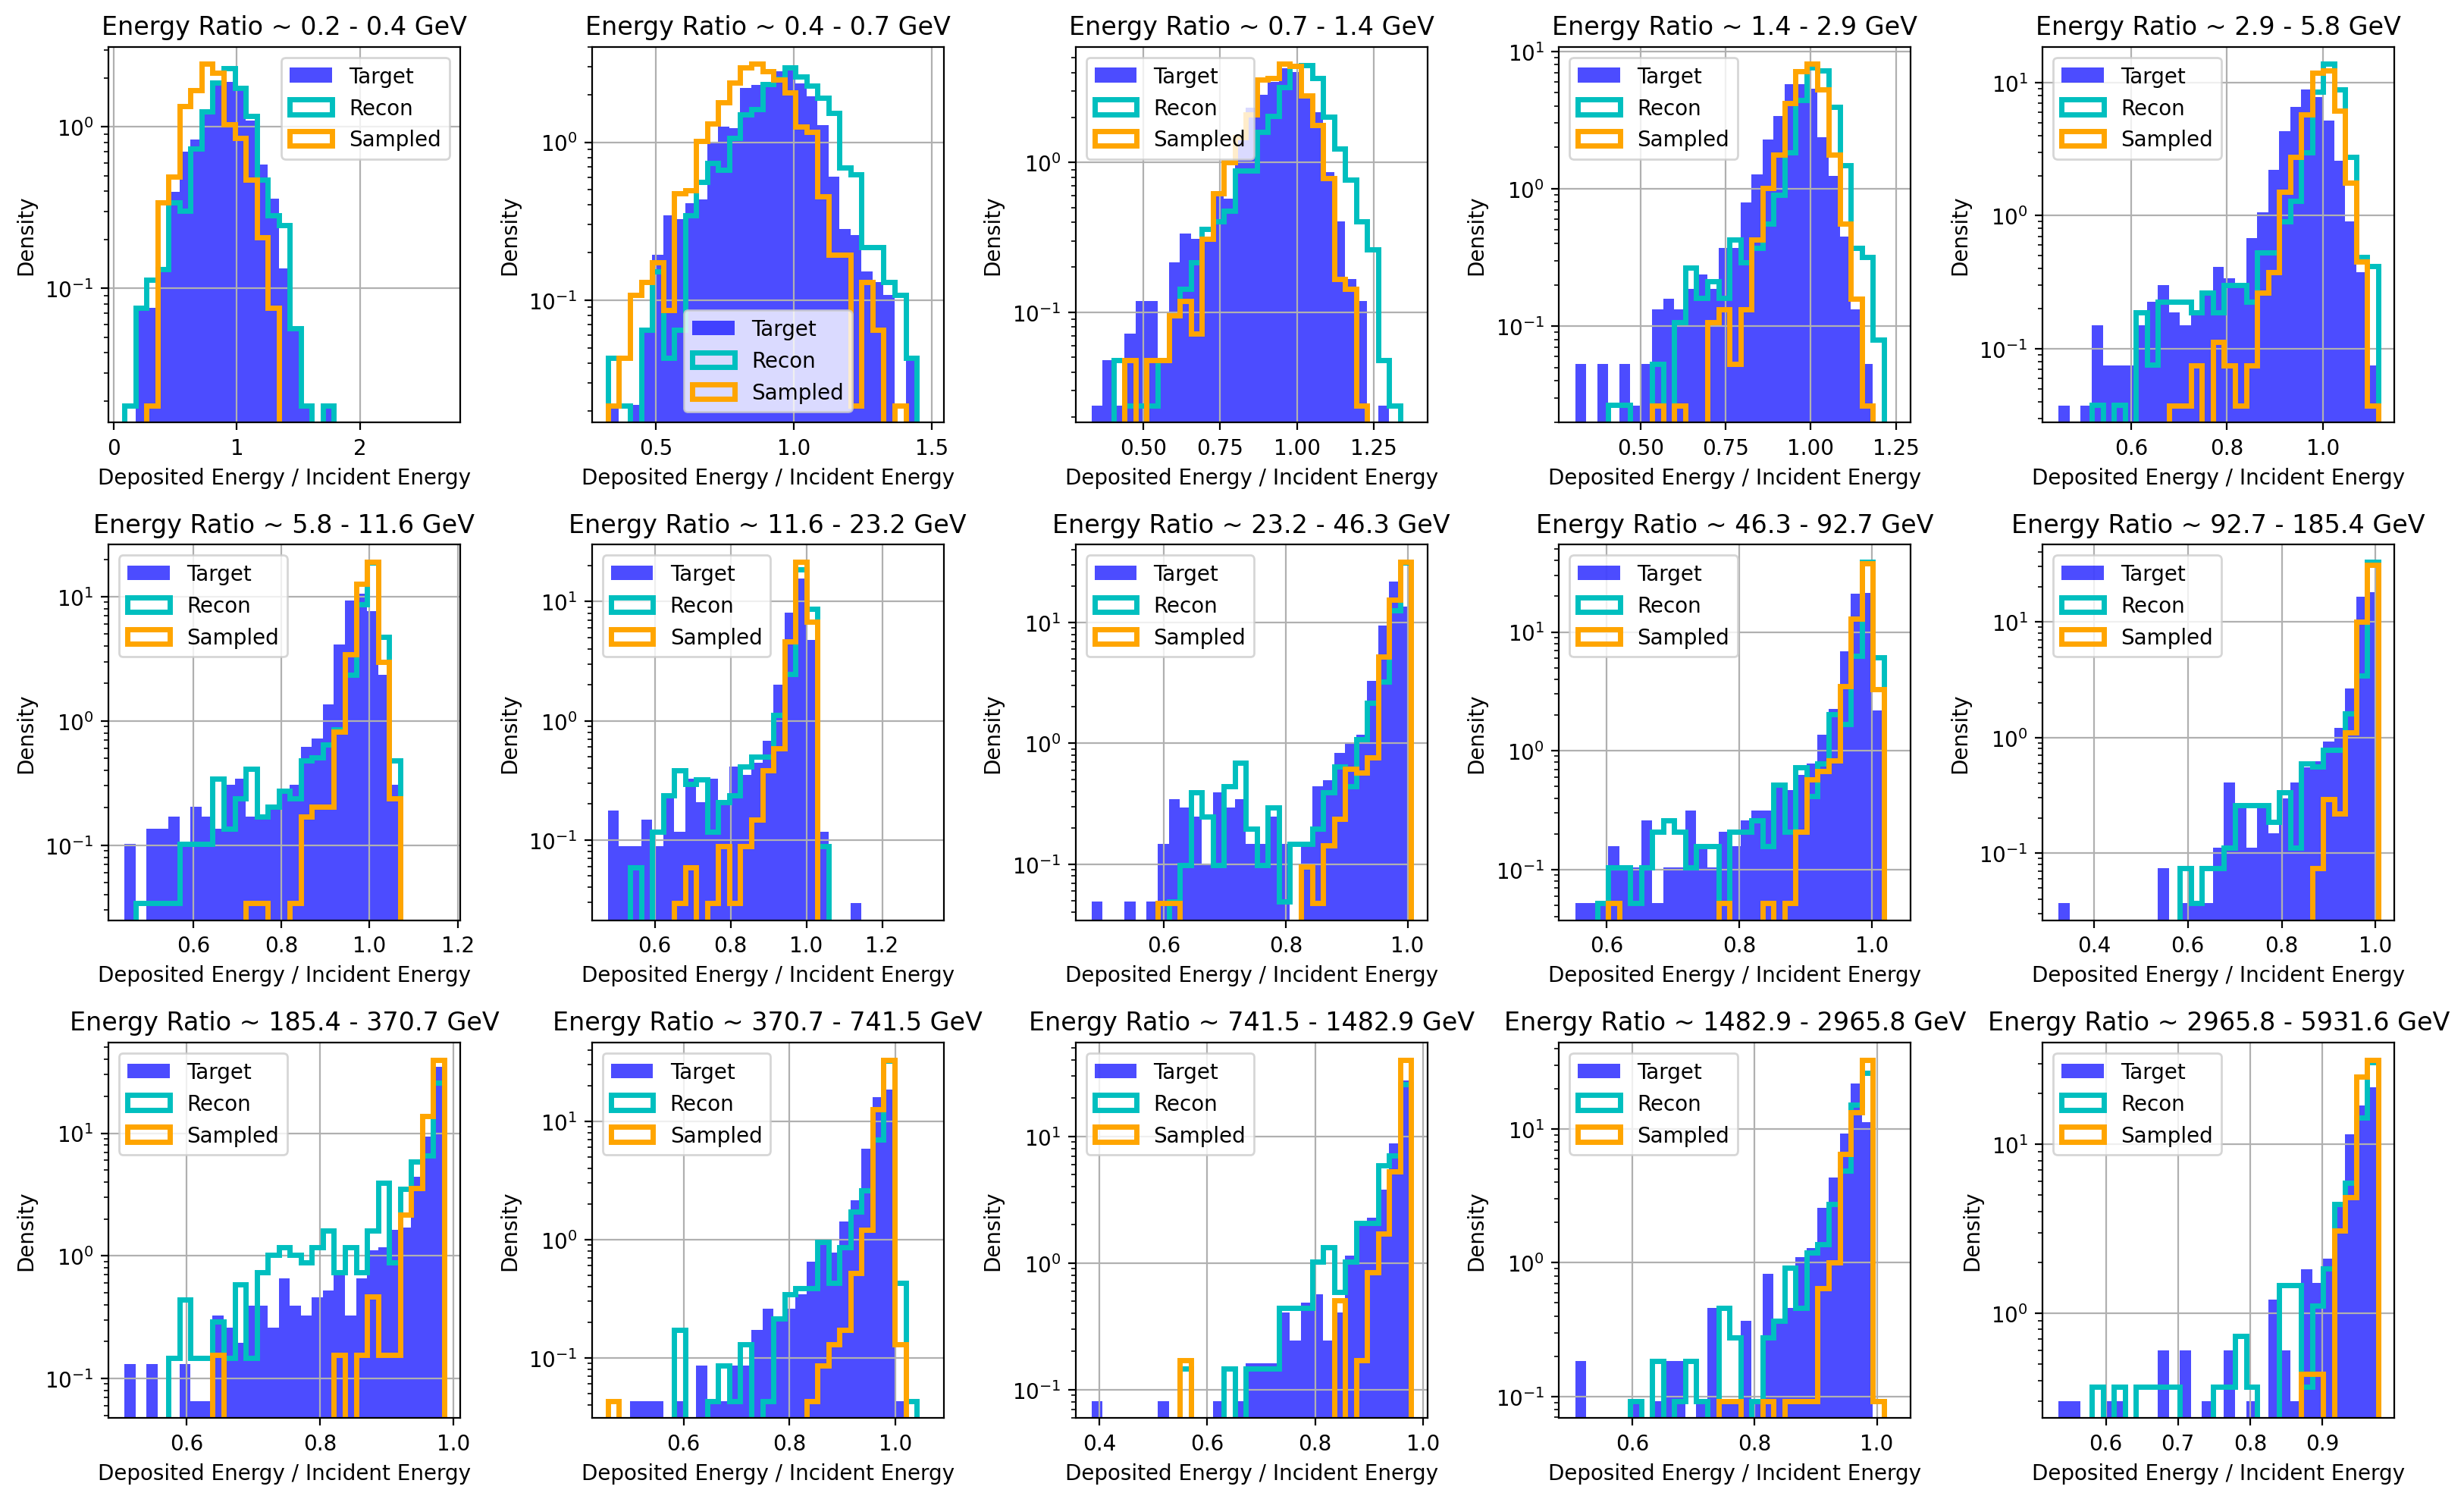

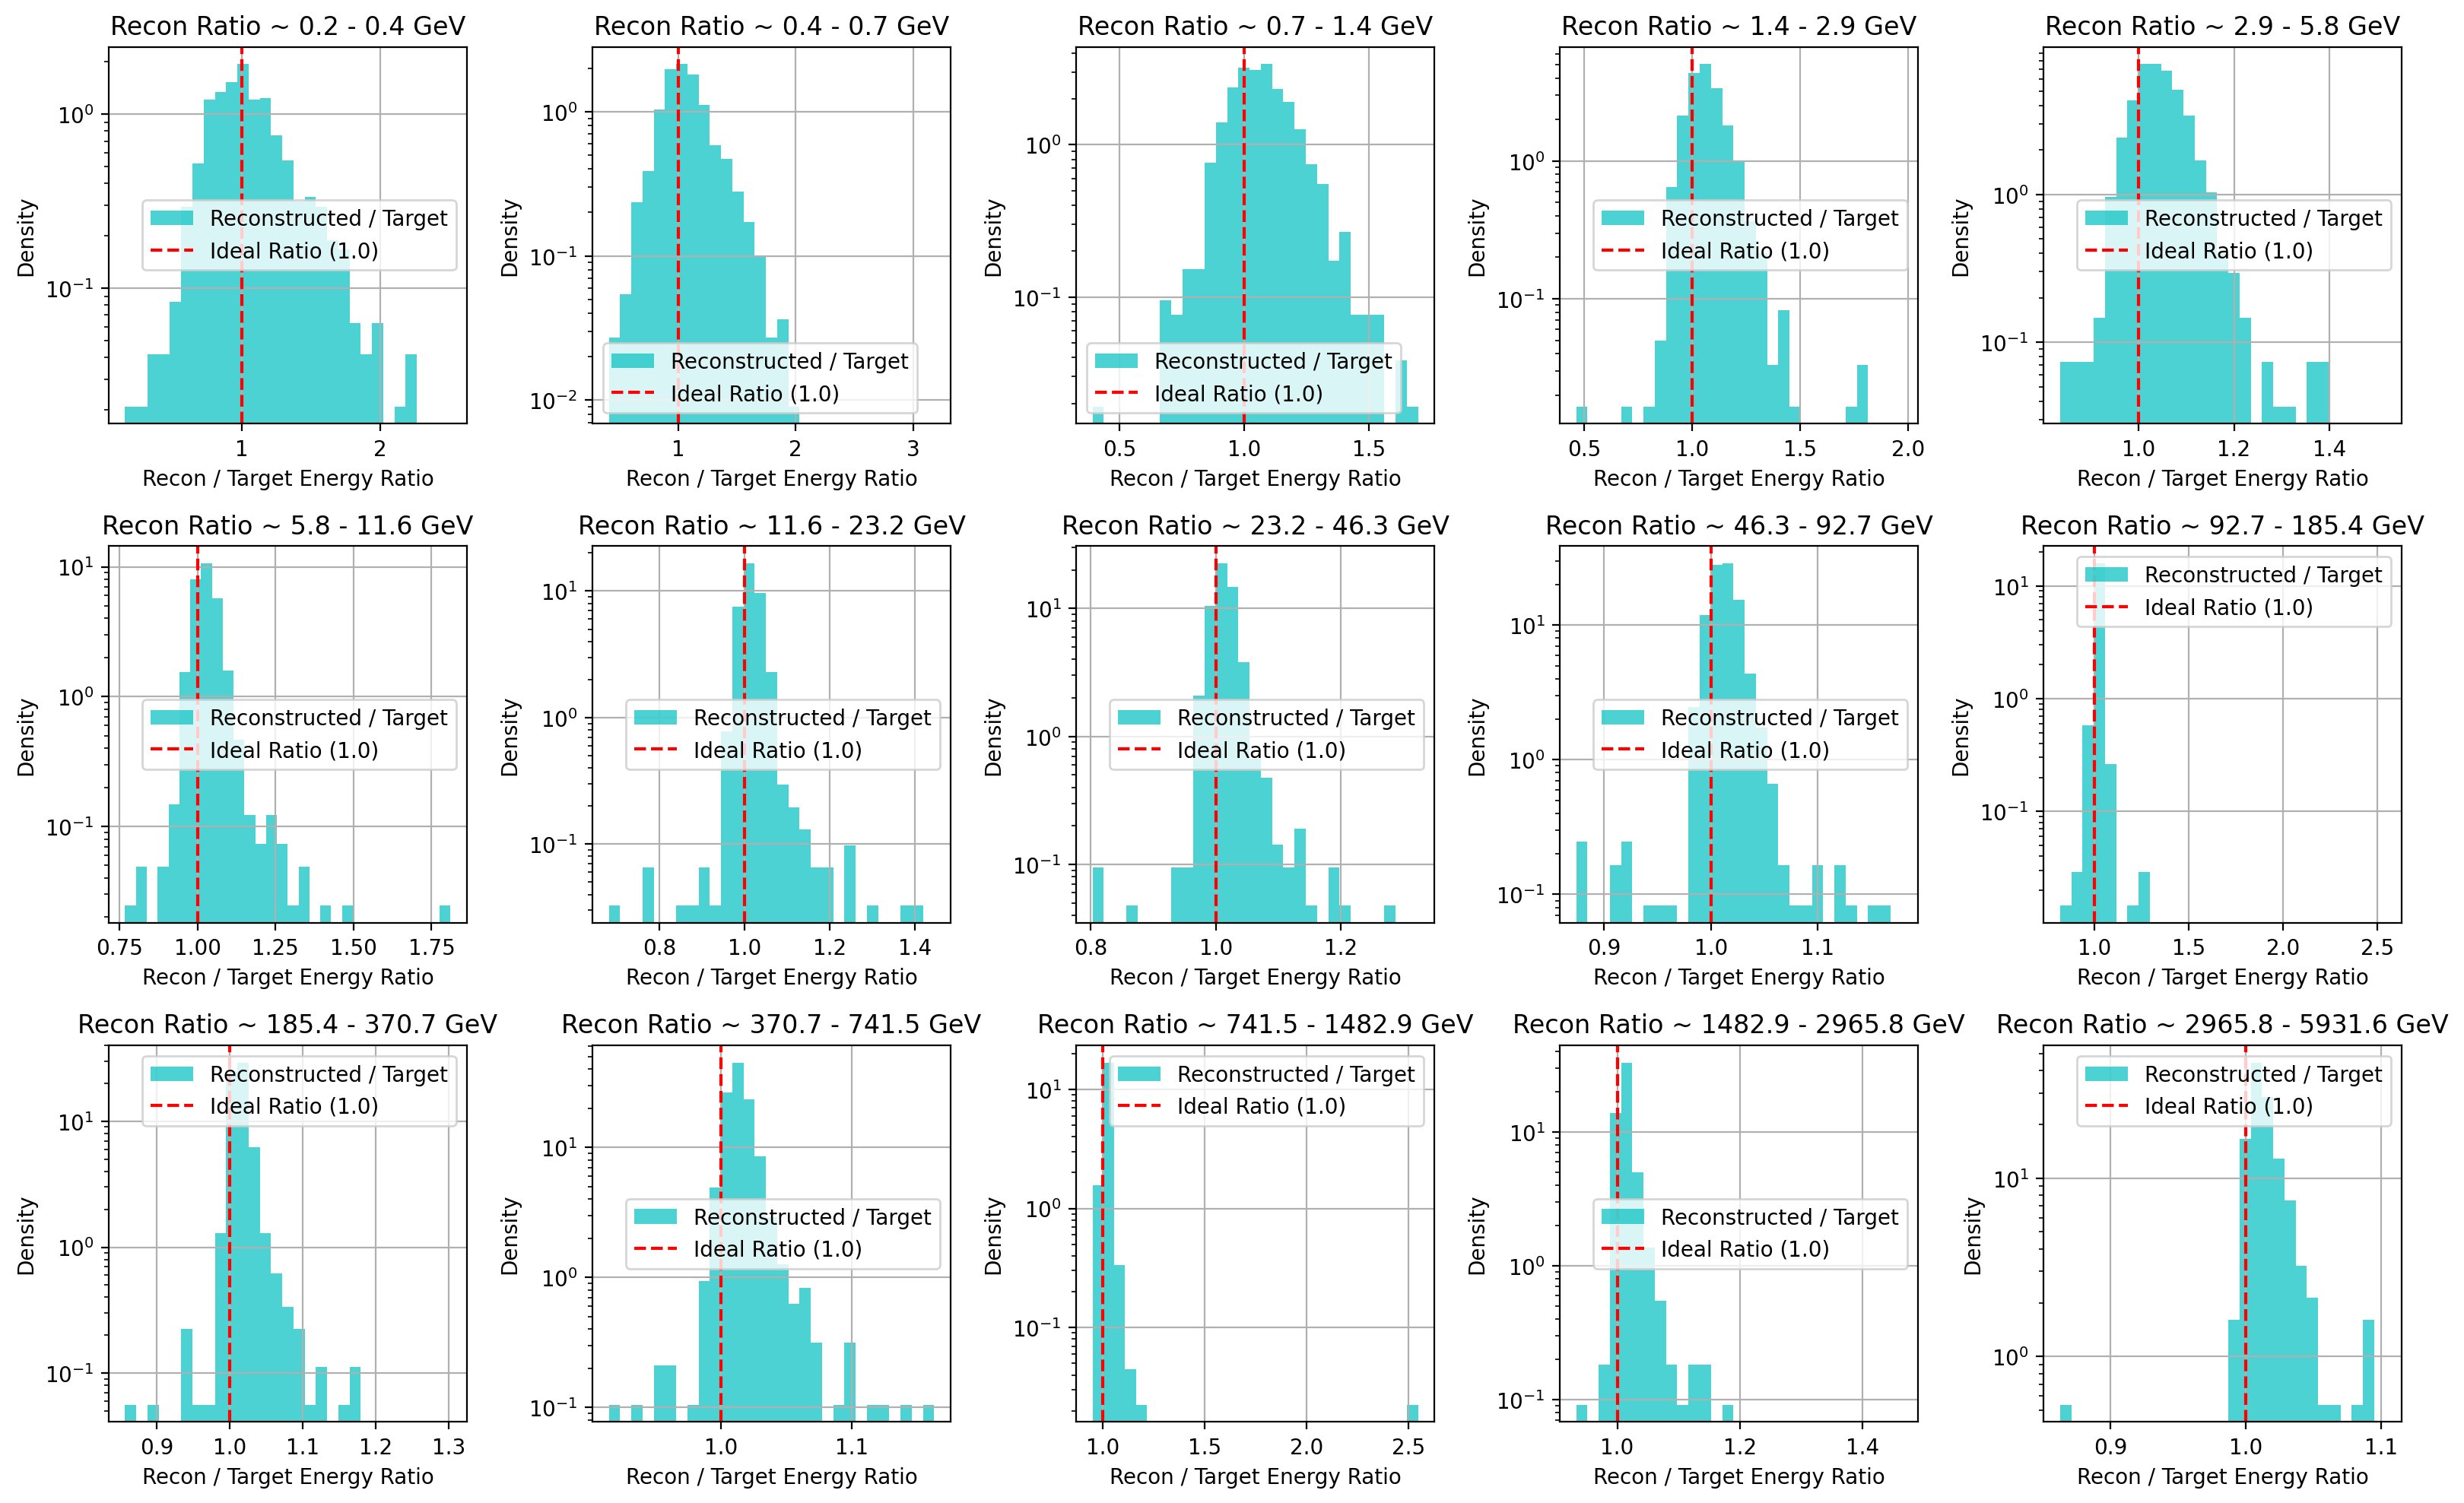

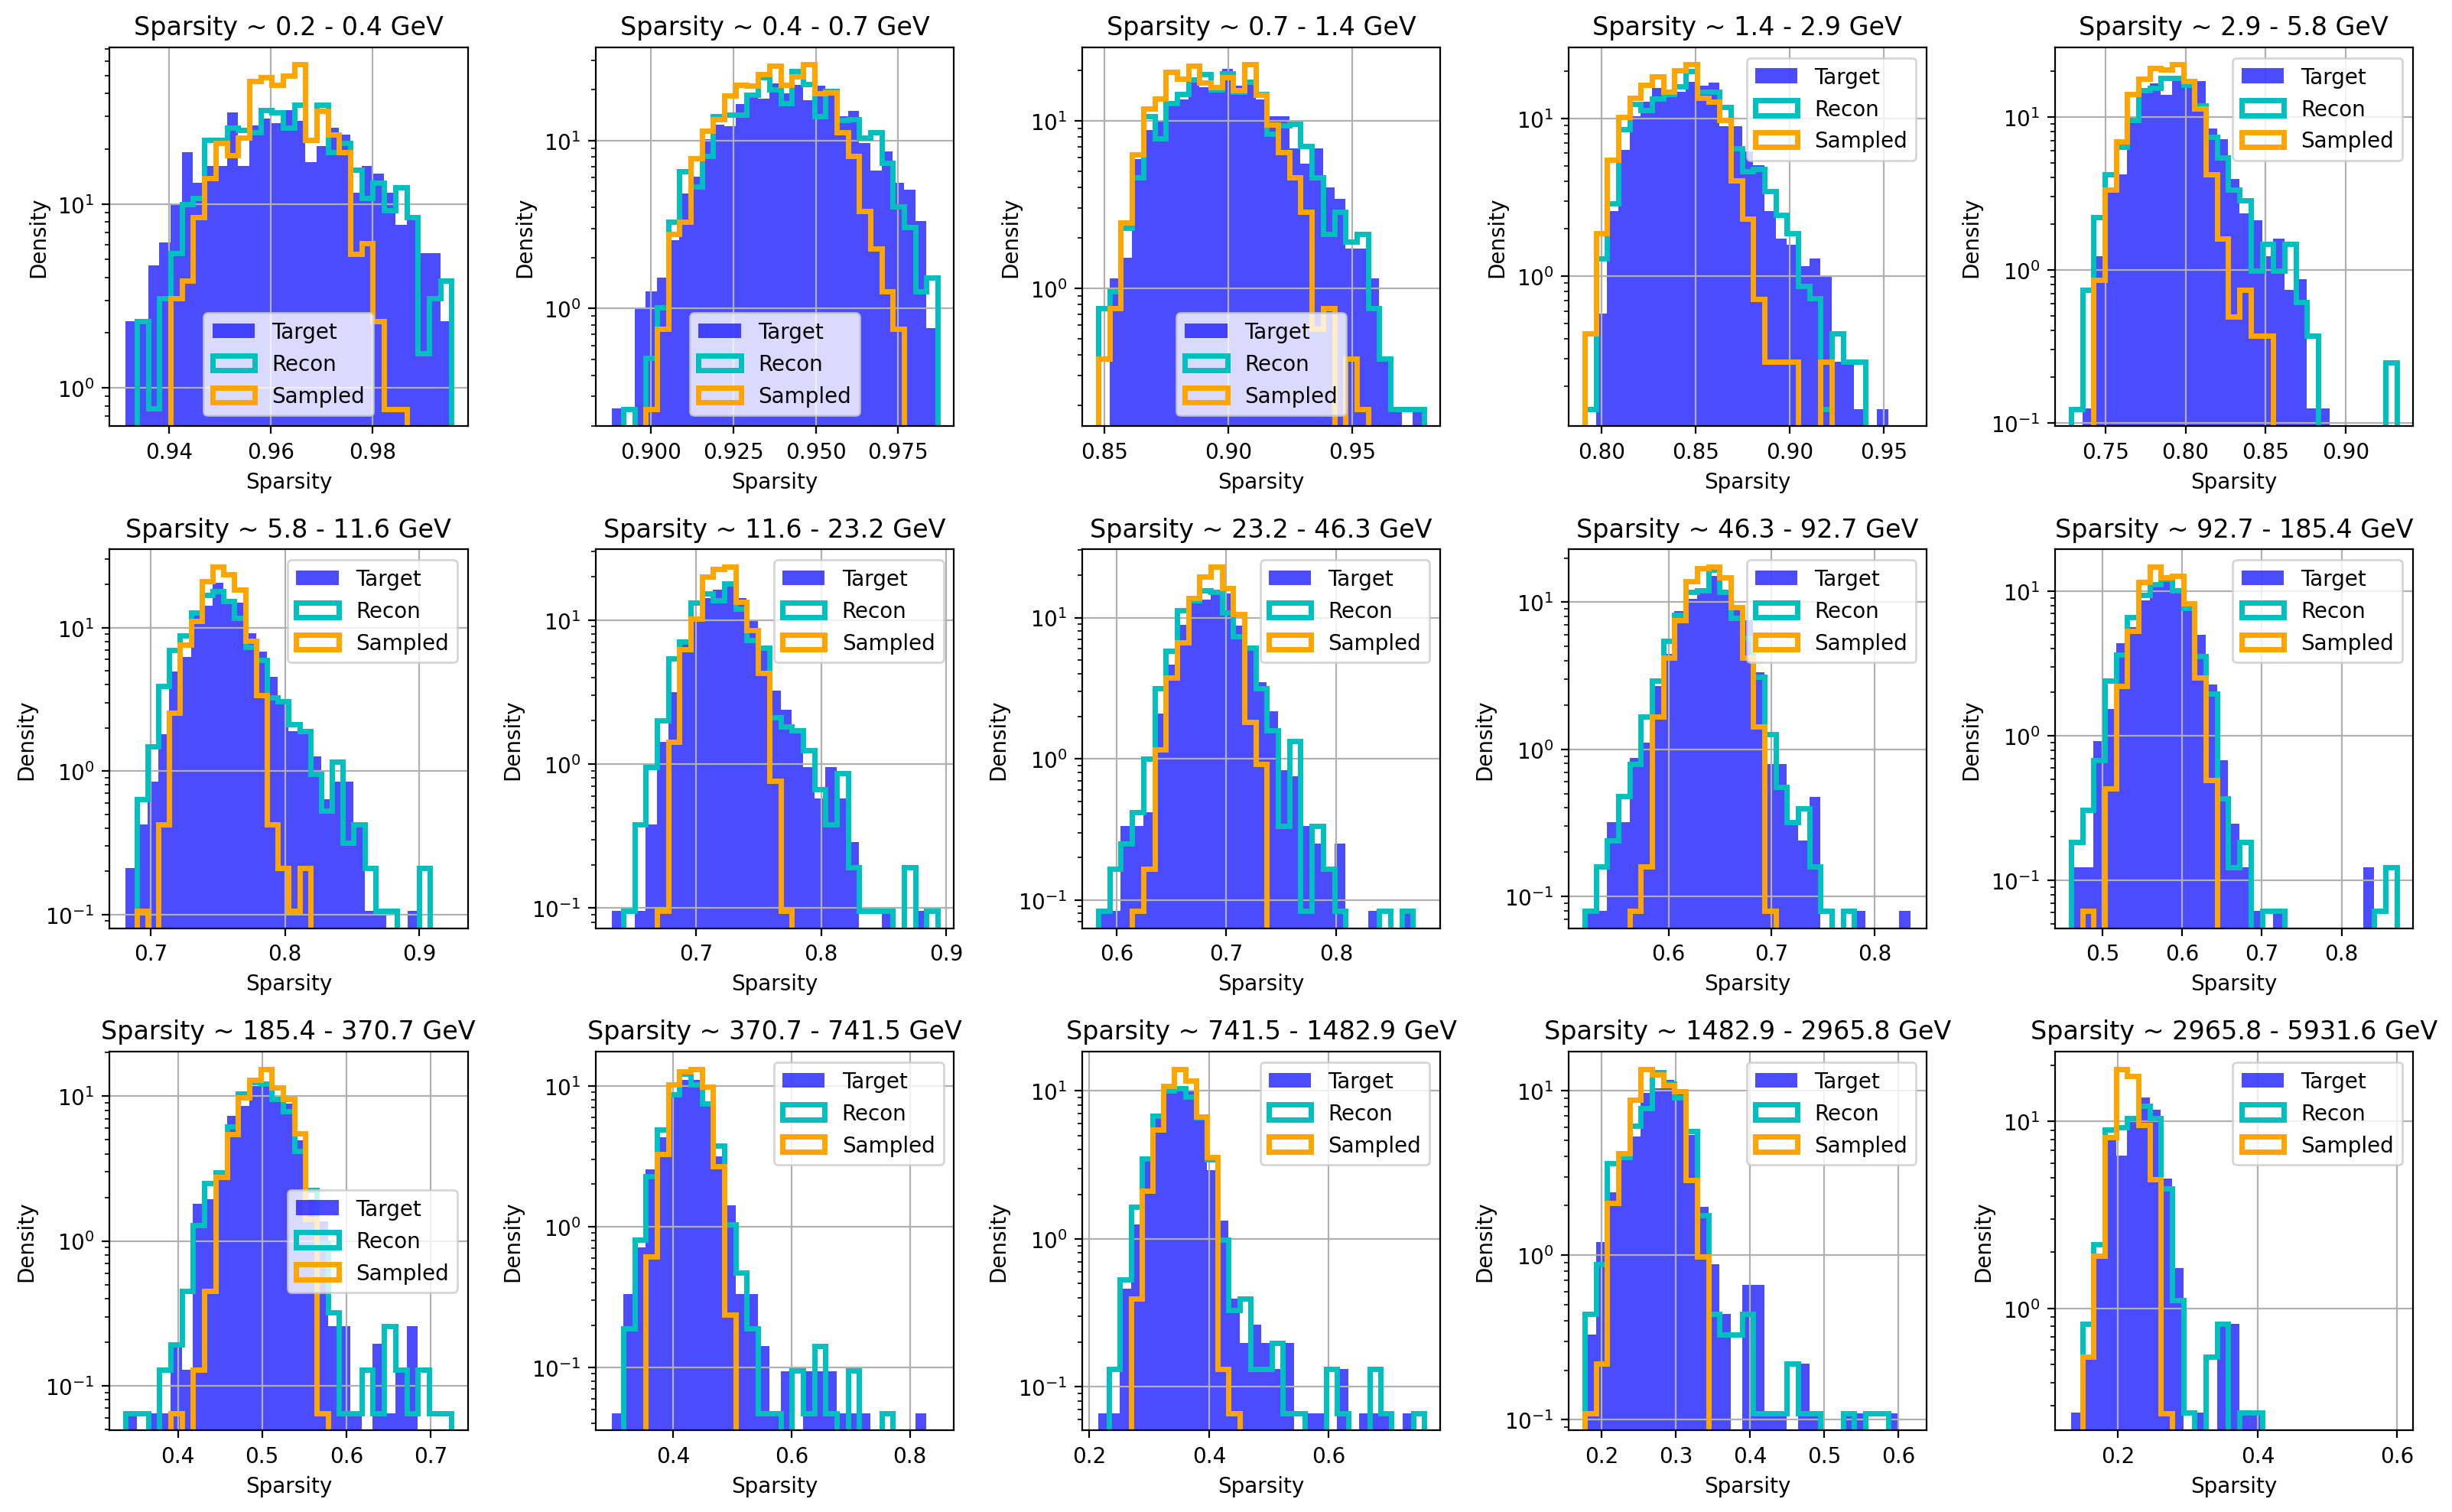

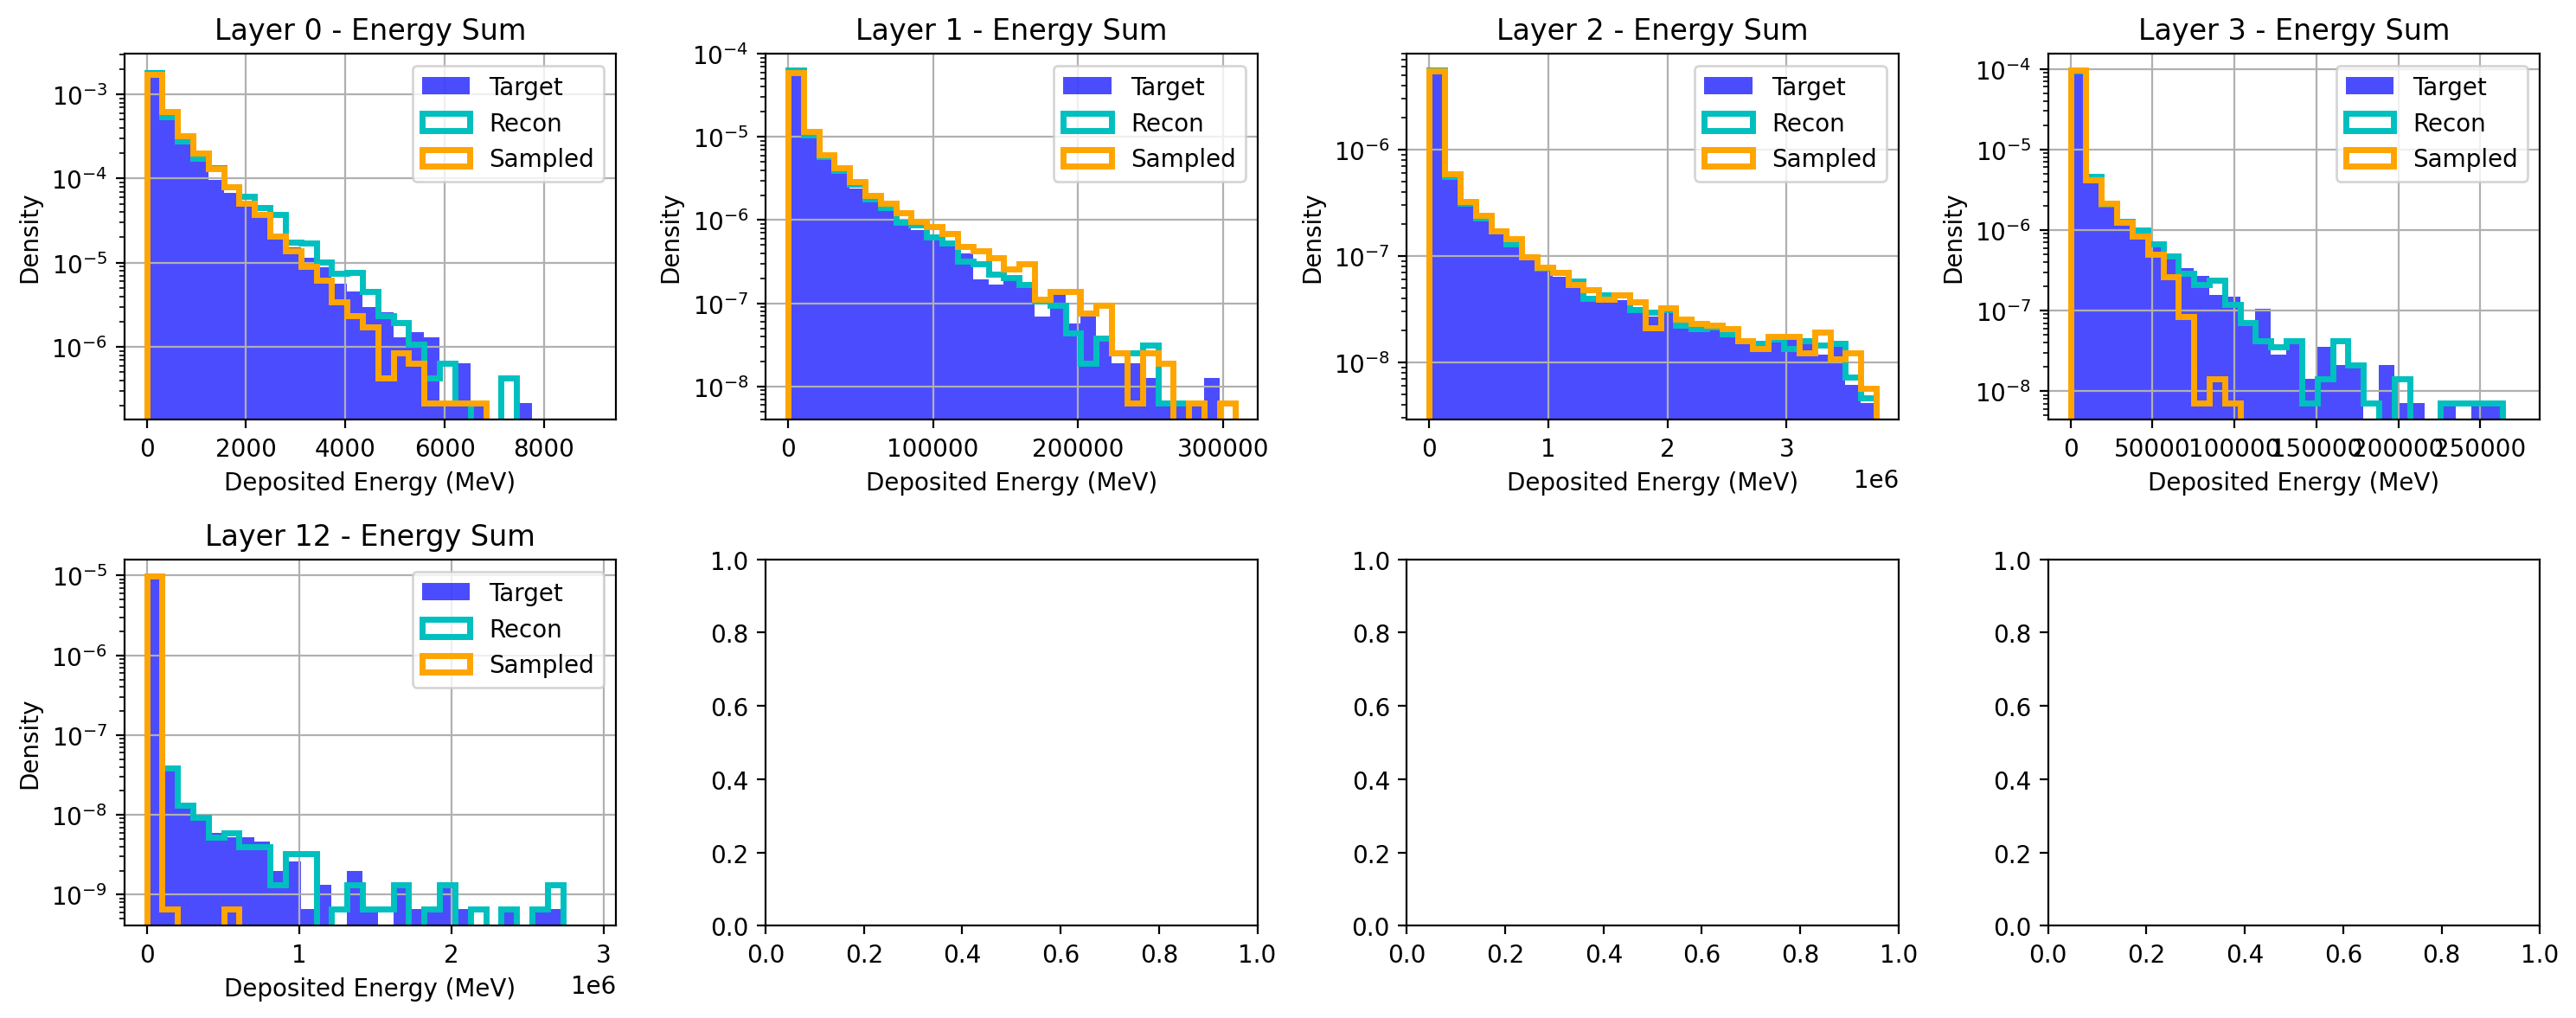

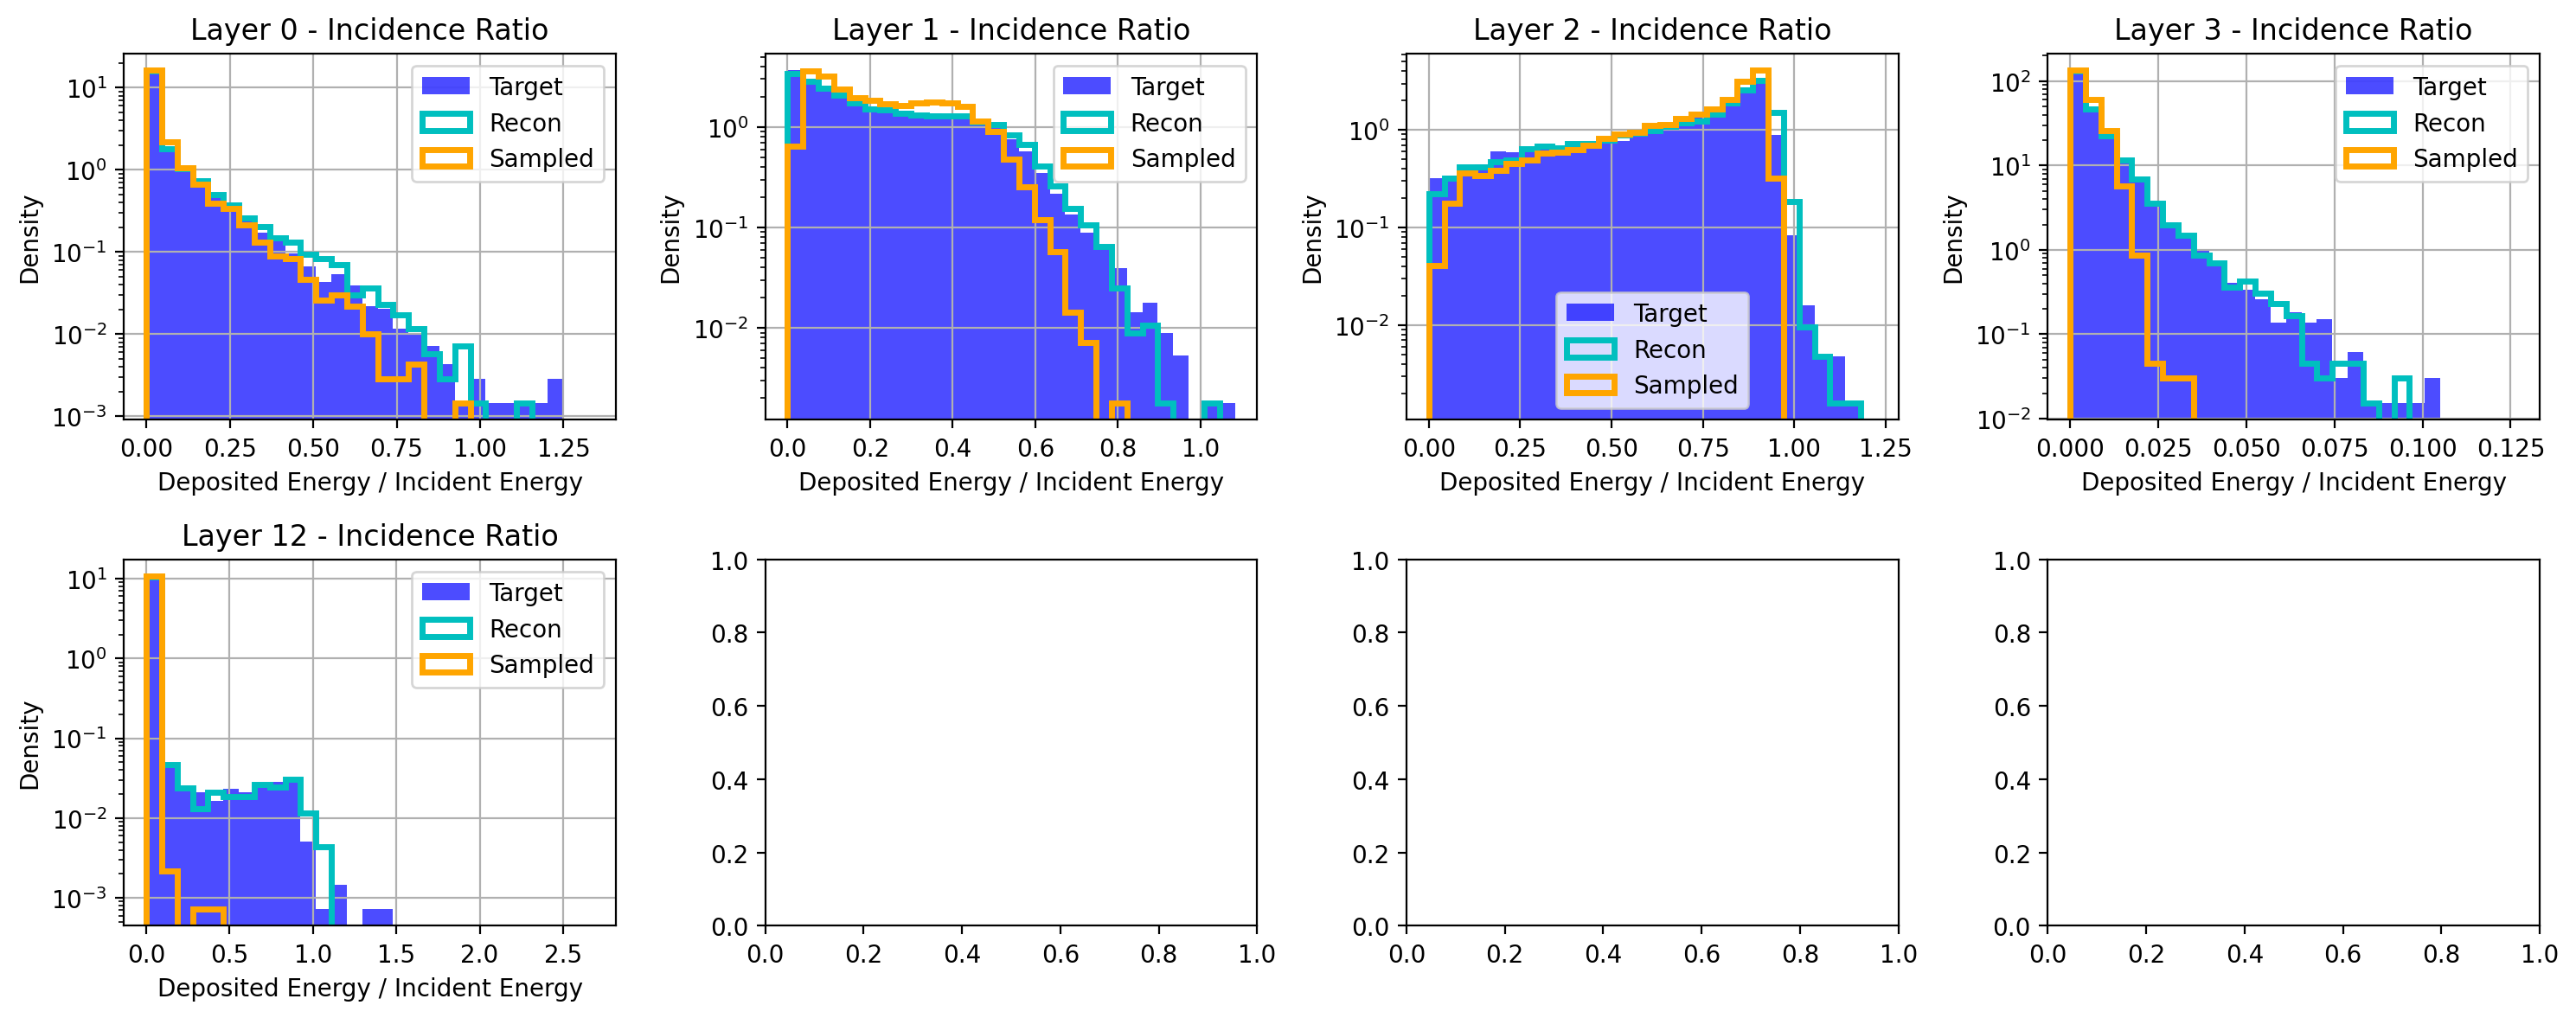

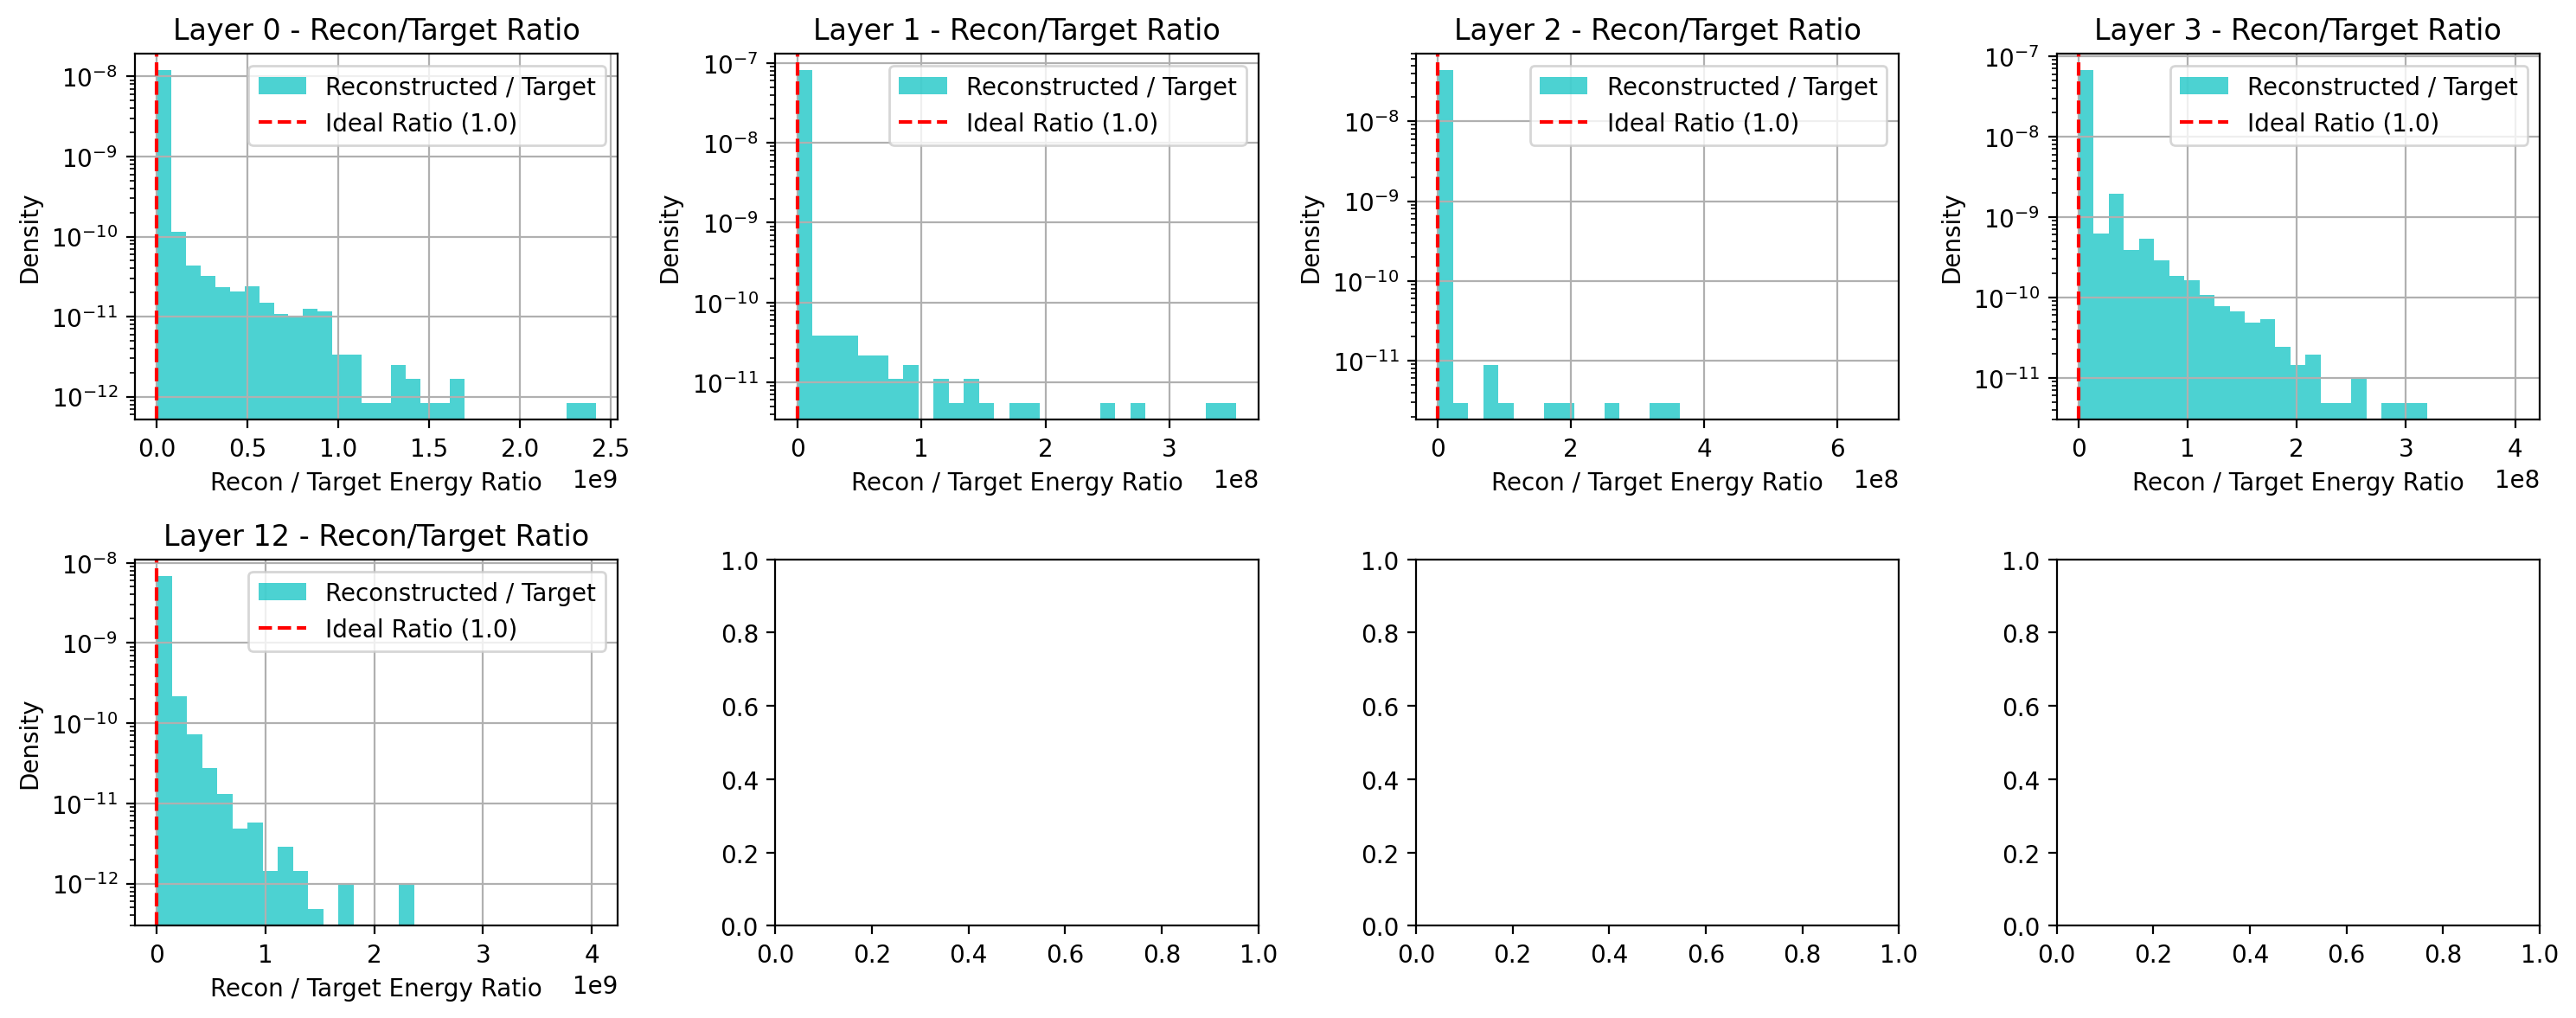

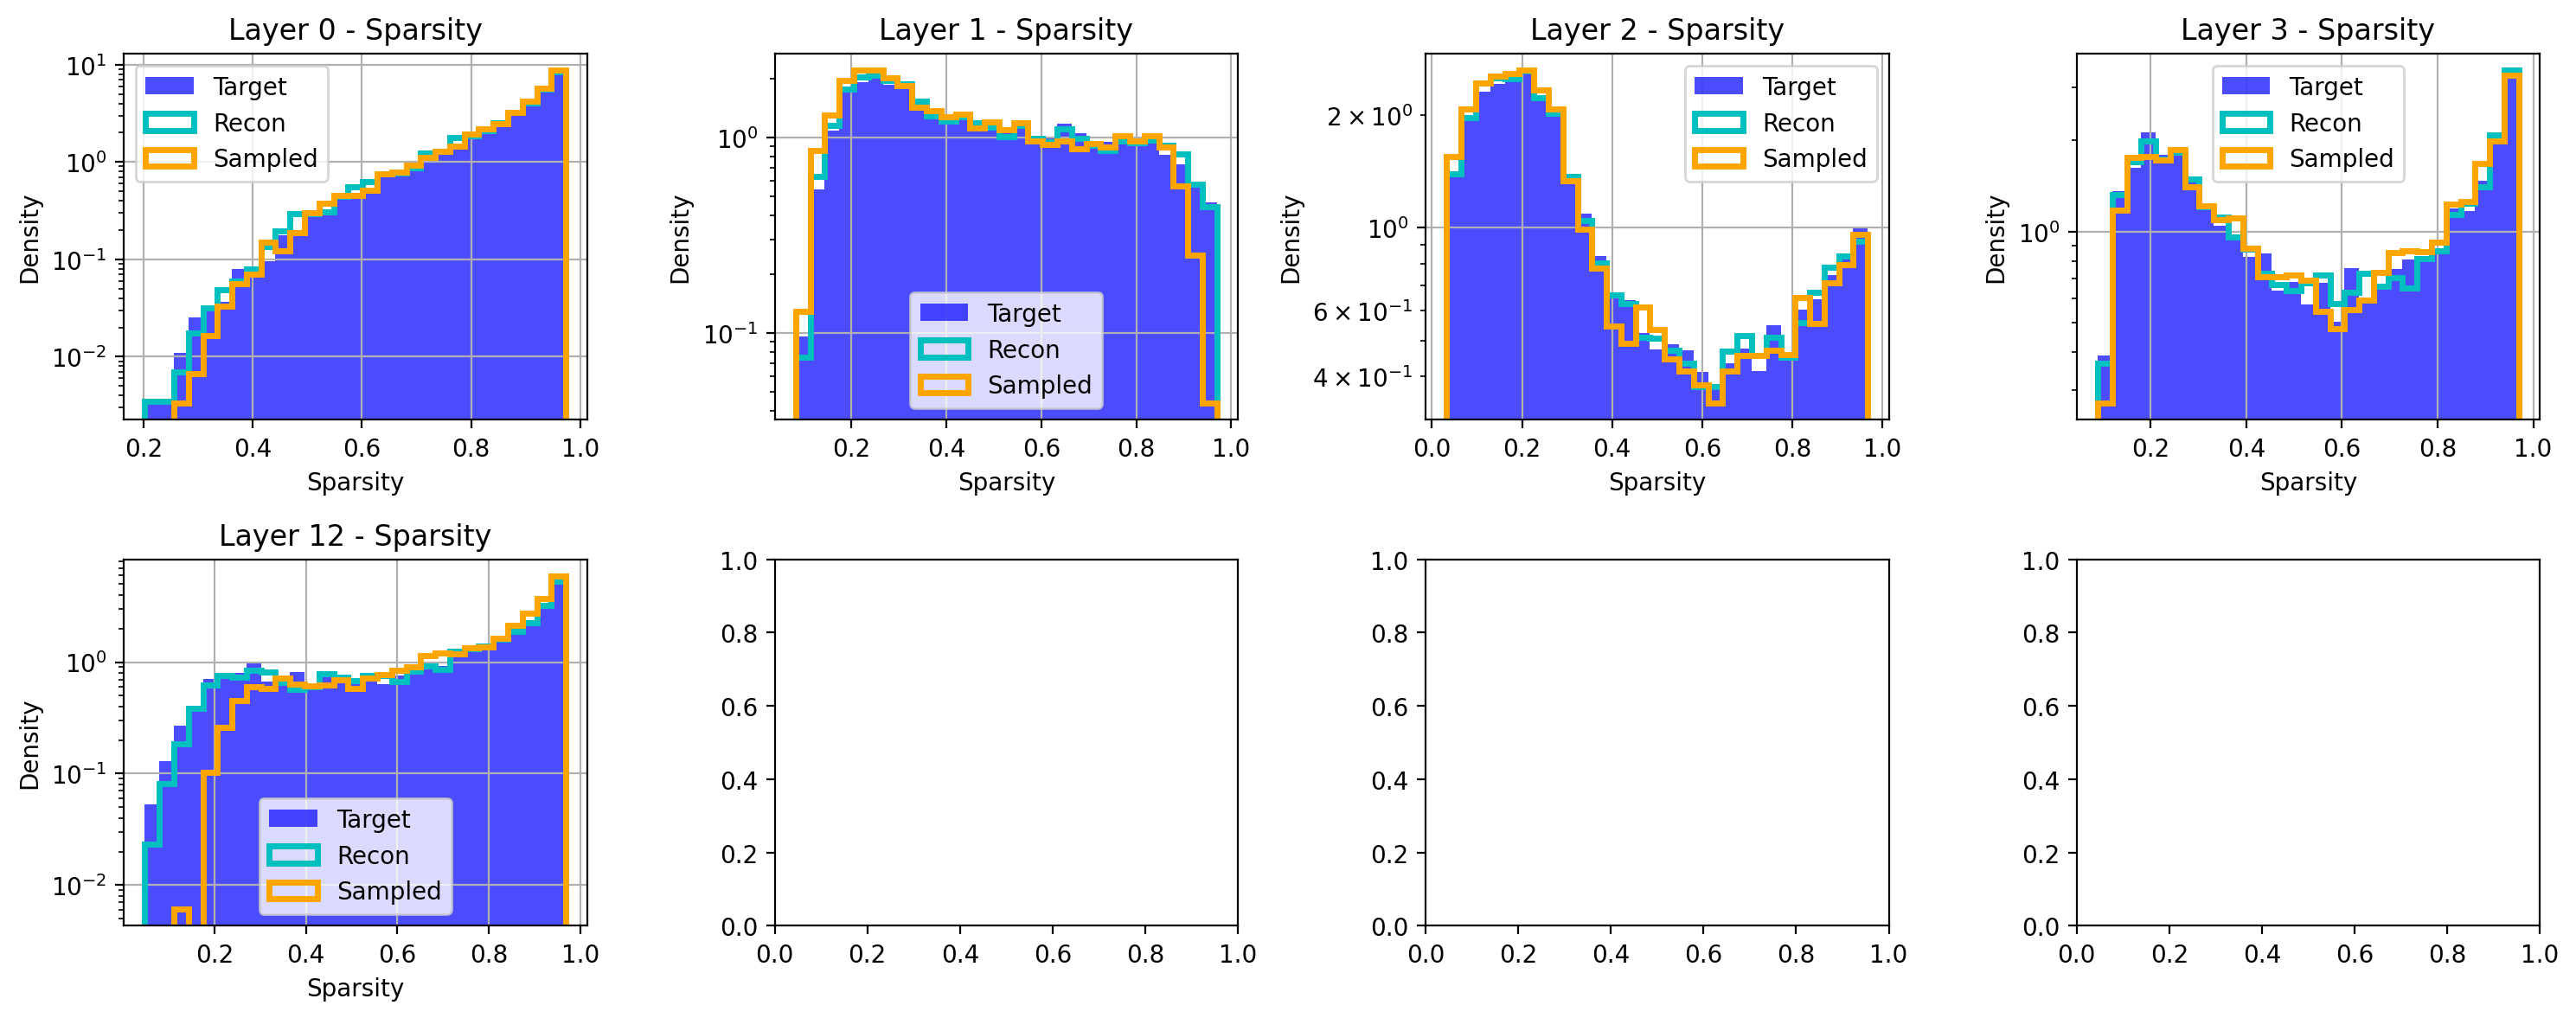

In [5]:
from utils.plots import vae_plots
overall_fig, fig_energy_sum, fig_incidence_ratio, fig_target_recon_ratio, fig_sparsity, fig_sum_layers, fig_incidence_layers, fig_ratio_layers, fig_sparsity_layers = vae_plots(self._config,
    self.incident_energy, self.showers, self.showers_recon, self.showers_prior)


In [ ]:
naive_HEP_obj = HepMetrics(self)

naive_HEPMetrics = get_fpd_kpd_metrics(
    np.array(self.showers), 
    np.array(self.showers_prior), 
    False, naive_HEP_obj.hlf, naive_HEP_obj.ref_hlf, if_Atlas=True
)

fpd_naive = naive_HEPMetrics[0]
fpd_naive_err = naive_HEPMetrics[1]
kpd_naive = naive_HEPMetrics[2]
kpd_naive_err = naive_HEPMetrics[3]

print(f"Naive FPD: {fpd_naive} +/- {fpd_naive_err}")
print(f"Naive KPD: {kpd_naive} +/- {kpd_naive_err}")

AttributeError: 'HighLevelFeatures_ATLAS_regular' object has no attribute 'Einc'

In [ ]:
# run evaluation (will be the epoch of the file, not necessarily epoch 0)
self.evaluate_vae(self.data_mgr.val_loader, epoch=0)

In [ ]:
import utils.plots
importlib.reload(utils.plots)
from utils.plots import corr_plots
corr_plots(self._config, self.post_logits, self.post_samples, self.prior_samples)


In [ ]:
p_size = self._config.rbm.latent_nodes_per_p

p0 = self.post_samples[:5*self._config.data.batch_size_tr,:p_size].to(self._device)
p1 = self.post_logits[:5*self._config.data.batch_size_tr,:p_size].to(self._device)
p2 = self.post_logits[:5*self._config.data.batch_size_tr,p_size:2*p_size].to(self._device)
p3 = self.post_logits[:5*self._config.data.batch_size_tr,2*p_size:].to(self._device)

correlations = torch.corrcoef(torch.cat([p0, p1, p2, p3], dim=1).cpu().T).numpy()
#0 out diagonal
np.fill_diagonal(correlations, 0)
#0 out first p_size x p_size block
correlations[:p_size, :p_size] = 0
fig = plt.figure(figsize=(8,8))
plt.imshow(correlations, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.gca().invert_yaxis()
plt.show()

# same plot, for self.post_samples
p1_samp = self.post_samples[:5*self._config.data.batch_size_tr,p_size:2*p_size].to(self._device)
p2_samp = self.post_samples[:5*self._config.data.batch_size_tr,2*p_size:3*p_size].to(self._device)
p3_samp = self.post_samples[:5*self._config.data.batch_size_tr,3*p_size:].to(self._device)
correlations_samp = torch.corrcoef(torch.cat([p0, p1_samp, p2_samp, p3_samp], dim=1).cpu().T).numpy()
#0 out diagonal
np.fill_diagonal(correlations_samp, 0)
#0 out first p_size x p_size block
correlations_samp[:p_size, :p_size] = 0
fig = plt.figure(figsize=(8,8))
plt.imshow(correlations_samp, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.gca().invert_yaxis()
plt.show()

In [ ]:
def sigmoid_C_k(weights_ax, weights_bx, weights_cx,
                 pa_state, pb_state, pc_state, bias_x) -> torch.Tensor:
    """partition_state()

    :param weights_a (torch.Tensor) : (n_nodes_a, n_nodes_x)
    :param weights_b (torch.Tensor) : (n_nodes_b, n_nodes_x)
    :param weights_c (torch.Tensor) : (n_nodes_c, n_nodes_x)
    :param pa_state (torch.Tensor) : (batch_size, n_nodes_a)
    :param pb_state (torch.Tensor) : (batch_size, n_nodes_b)
    :param pc_state (torch.Tensor) : (batch_size, n_nodes_c)
    :param bias_x (torch.Tensor) : (n_nodes_x)
    """
    p_activations = (torch.matmul(pa_state, weights_ax) +
                        torch.matmul(pb_state, weights_bx) +
                        torch.matmul(pc_state, weights_cx) + bias_x)
    return p_activations.detach()

In [ ]:
p_size = self._config.rbm.latent_nodes_per_p
p0 = self.post_samples[:self._config.data.batch_size_tr,:p_size].to(self._device)
p1 = self.post_logits[:self._config.data.batch_size_tr,:p_size].to(self._device)
p2 = self.post_logits[:self._config.data.batch_size_tr,p_size:2*p_size].to(self._device)
p3 = self.post_logits[:self._config.data.batch_size_tr,2*p_size:].to(self._device)

W01 = self.model.prior.weight_dict['01']
W02 = self.model.prior.weight_dict['02']
W03 = self.model.prior.weight_dict['03']

W12 = self.model.prior.weight_dict['12']
W13 = self.model.prior.weight_dict['13']
W23 = self.model.prior.weight_dict['23']
# precompute the needed transposes only once
W12_T = W12.T
W13_T = W13.T
W23_T = W23.T

b1 = self.model.prior.bias_dict['1']
b2 = self.model.prior.bias_dict['2']
b3 = self.model.prior.bias_dict['3']

p3_ans = sigmoid_C_k(W03,   W13,   W23,   p0, torch.sigmoid(p1), torch.sigmoid(p2), b3)
p2_ans = sigmoid_C_k(W02,   W12, W23_T,   p0, torch.sigmoid(p1), torch.sigmoid(p3), b2)
p1_ans = sigmoid_C_k(W01, W12_T, W13_T,   p0, torch.sigmoid(p2), torch.sigmoid(p3), b1)

In [ ]:
plt.hist((p1 - p1_ans).pow(2).mean(dim=1).cpu(), label='p1')
plt.hist((p2 - p2_ans).pow(2).mean(dim=1).cpu(), label='p2', alpha=0.7)
plt.hist((p3 - p3_ans).pow(2).mean(dim=1).cpu(), label='p3', alpha=0.5)
plt.xlabel("Mean Squared Error")
plt.ylabel("Frequency")
plt.legend()

plt.show()


In [ ]:
corrMet = CorrelationMetrics(self)  # pass the loaded engine

corrMet.run(self, idx=149) # run

# save figs and metrics
corrMet.flush(self._config.run_path)

In [ ]:
self.evaluate_vae(self.data_mgr.val_loader, epoch=0)

In [ ]:
p_size = self._config.rbm.latent_nodes_per_p

probs = torch.sigmoid(self.post_logits).mean(dim=0).cpu()
num_samples = self.post_logits.shape[0]
expanded_probs = probs.expand(num_samples, -1)
naive_samples = torch.bernoulli(expanded_probs)
p0_slice = self.post_samples[:,:p_size]
naive_samples = torch.cat((p0_slice, naive_samples), dim=1)
print(naive_samples.shape)
print(self.post_samples.shape)

In [ ]:
batch_size = self.data_mgr.val_loader.batch_size
bs = [batch[0].shape[0] for batch in self.data_mgr.val_loader]
ar_size = np.sum(bs)
ar_input_size = self._config.data.z * self._config.data.r * self._config.data.phi
ar_latent_size = self._config.rbm.latent_nodes_per_p

showers_naive = torch.zeros((ar_size, ar_input_size), dtype=torch.float32)
print(batch_size)
self.model.eval()
for i, (x, x0) in enumerate(self.data_mgr.val_loader):
    # x = x.to(self.device)
    # x0 = x0.to(self.device)
    x_reduce = self._reduce(x, x0)
    # output = self.model((x_reduce, x0))
    # # Get prior samples
    # prior_samples = self.model.prior.block_gibbs_sampling_cond(p0 = output[2][0])
    # print(prior_samples)


    # Split along dim=1 into 4 chunks

    naive_sample = naive_samples[i*batch_size:(i+1)*batch_size,:]
    split_samples = torch.split(naive_sample, p_size, dim=1)
    self.model.to(torch.device("cpu"))

    _, shower_naive = self.model.decode(split_samples, x_reduce, x0)
    showers_naive[i*batch_size:(i+1)*batch_size,:] = self._reduceinv(shower_naive, x0).detach().cpu()
    print(f"Processed batch {i+1}")
print(showers_naive.shape)


In [ ]:
from utils.plots import vae_plots
overall_fig, fig_energy_sum, fig_incidence_ratio, fig_target_recon_ratio, fig_sparsity, fig_sum_layers, fig_incidence_layers, fig_ratio_layers, fig_sparsity_layers = vae_plots(self._config,
    self.incident_energy, self.showers, self.showers_recon, showers_naive)
